In [32]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional


In [33]:
!wget --no-check-certificate \
    https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv \
    -O /tmp/bbc-text.csv

--2022-01-02 04:09:34--  https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.107.128, 173.194.216.128, 173.194.217.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.107.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [text/csv]
Saving to: ‘/tmp/bbc-text.csv’

/tmp/bbc-text.csv   100%[===================>]   4.82M  --.-KB/s    in 0.03s   

2022-01-02 04:09:34 (162 MB/s) - ‘/tmp/bbc-text.csv’ saved [5057493/5057493]



In [34]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
vocab_size = 5000 
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' 
training_portion = .8

In [36]:
articles = []
labels = []

with open("/tmp/bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        article = row[1]
        for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
            article = article.replace(' ', ' ')
        articles.append(article)

In [37]:
train_size = int(len(articles) * training_portion)

train_articles = articles[0: train_size]
train_labels = labels[0: train_size]

validation_articles = articles[train_size:]
validation_labels = labels[train_size:]

In [38]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_articles)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [39]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

In [40]:
model = Sequential()

model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(embedding_dim)))
model.add(Dense(6, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          320000    
                                                                 
 dropout_1 (Dropout)         (None, None, 64)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 386,822
Trainable params: 386,822
Non-trainable params: 0
_________________________________________________________________


In [41]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy'],
)

In [42]:
num_epochs = 10
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/10
56/56 - 20s - loss: 1.6073 - accuracy: 0.2899 - val_loss: 1.3805 - val_accuracy: 0.4809 - 20s/epoch - 358ms/step
Epoch 2/10
56/56 - 13s - loss: 1.0720 - accuracy: 0.5584 - val_loss: 0.9221 - val_accuracy: 0.8090 - 13s/epoch - 234ms/step
Epoch 3/10
56/56 - 12s - loss: 1.0089 - accuracy: 0.6388 - val_loss: 1.0543 - val_accuracy: 0.5124 - 12s/epoch - 221ms/step
Epoch 4/10
56/56 - 13s - loss: 0.6866 - accuracy: 0.8331 - val_loss: 0.5553 - val_accuracy: 0.8202 - 13s/epoch - 226ms/step
Epoch 5/10
56/56 - 12s - loss: 0.4210 - accuracy: 0.9129 - val_loss: 0.3876 - val_accuracy: 0.9101 - 12s/epoch - 221ms/step
Epoch 6/10
56/56 - 13s - loss: 0.1759 - accuracy: 0.9635 - val_loss: 0.2551 - val_accuracy: 0.9213 - 13s/epoch - 224ms/step
Epoch 7/10
56/56 - 13s - loss: 0.0683 - accuracy: 0.9876 - val_loss: 0.3102 - val_accuracy: 0.9101 - 13s/epoch - 224ms/step
Epoch 8/10
56/56 - 13s - loss: 0.0681 - accuracy: 0.9831 - val_loss: 0.2296 - val_accuracy: 0.9326 - 13s/epoch - 224ms/step
Epoch 9/

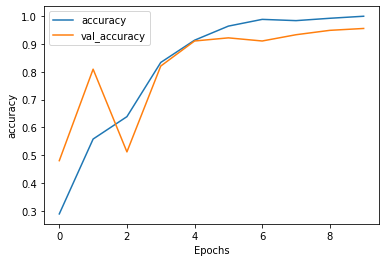

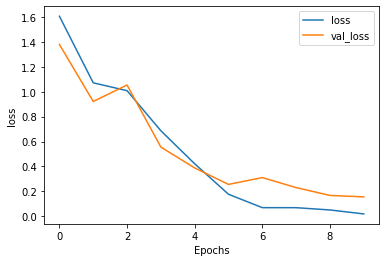

In [43]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")